# In memory dataset

This notebooks explains an alternative way of measuring where the raw data is not written directly to a sqlite database file but only kept in memory with the ability to export the data after the measurement is completed. This may significantly speed up measurements where a lot of data is acquired but there is no protection against any data lose that may happen during a measurement. (Power loss, computer crash etc.) However, there may be situations where this trade-off is worthwhile. Please do only use the in memory dataset for measurements if you understand the risks. 

In [1]:
%matplotlib inline
import numpy.random as rd
import matplotlib.pyplot as plt
import numpy as np

import qcodes as qc
from qcodes.dataset import (
    load_or_create_experiment,
    load_by_guid,
    load_by_run_spec,
    initialise_or_create_database_at,
    Measurement,
    DataSetType,
)
from qcodes.tests.instrument_mocks import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)
from qcodes.dataset.plotting import plot_dataset

Here we set up two mock instruments and a database to measure into:

In [2]:
# preparatory mocking of physical setup

dac = DummyInstrument("dac", gates=["ch1", "ch2"])
dmm = DummyInstrumentWithMeasurement(name="dmm", setter_instr=dac)

station = qc.Station(dmm, dac)

In [3]:
initialise_or_create_database_at("./in_mem_example.db")
exp = load_or_create_experiment(experiment_name="in_mem_exp", sample_name="no sample")

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 335.28it/s]

0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 969.78it/s]

0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 232.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 526.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 516.60it/s]

And run a standard experiment writing data to the database: 

In [4]:
meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))  # now register the dependent oone

meas.write_period = 0.5

with meas.run() as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v), (dmm.v1, get_v))

    dataset1D = datasaver.dataset  # convenient to have for data access and plotting

Starting experimental run with id: 1. 


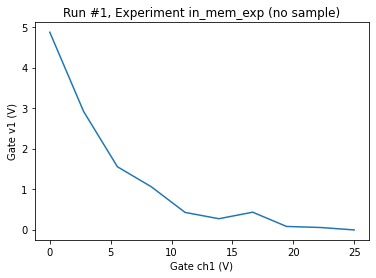

In [5]:
ax, cbax = plot_dataset(dataset1D)

The in memory measurement looks nearly identical with the only difference being that we explicitly pass in an Enum to select the dataset class that we want to use as a parameter to ``measurement.run``

The ``DataSetType`` Enum currently has 2 members representing the two different types of dataset supported.

In [6]:
with meas.run(dataset_class=DataSetType.DataSetInMem) as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v), (dmm.v1, get_v))
    datasetinmem = datasaver.dataset

Starting experimental run with id: 2. 


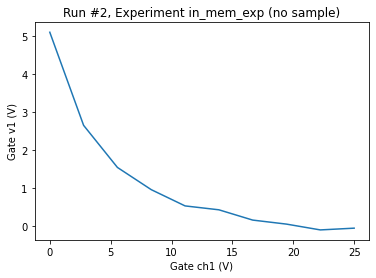

In [7]:
ax, cbax = plot_dataset(datasetinmem)

In [8]:
datasetinmem.run_id

2

When the measurement is performed in this way the data is not written to the database but the metadata (run_id, timestamps, snapshot etc.) is.

To preserve the raw data it must be exported it to another file format. See [Exporting QCoDes Datasets](./Exporting-data-to-other-file-formats.ipynb) for more information on exporting including how this can be done automatically.

In [9]:
datasetinmem.export("netcdf", path=".")

The `export_info` attribute contains information about locations where the file was exported to. We will use this below to show how the data may be reloaded from a netcdf file.

In [10]:
path_to_netcdf = datasetinmem.export_info.export_paths["nc"]
path_to_netcdf

'/home/runner/work/Qcodes/Qcodes/docs/examples/DataSet/qcodes_2_aaaaaaaa-0000-0000-0000-017e43aa1f3e.nc'

As expected we can see this file in the current directory.

In [11]:
!dir

Accessing-data-in-DataSet.ipynb
Benchmarking.ipynb
Cache
DataSet-class-walkthrough.ipynb
Dataset_Performance.ipynb
Exporting-data-to-other-file-formats.ipynb
Extracting-runs-from-one-DB-file-to-another.ipynb
InMemoryDataSet.ipynb
Linking\ to\ parent\ datasets.ipynb
Measuring\ X\ as\ a\ function\ of\ time.ipynb
Offline\ Plotting\ Tutorial.ipynb
Offline\ plotting\ with\ categorical\ data.ipynb
Offline\ plotting\ with\ complex\ data.ipynb
Paramtypes\ explained.ipynb
Pedestrian\ example\ of\ subscribing\ to\ a\ DataSet.ipynb
Performing-measurements-using-qcodes-parameters-and-dataset.ipynb
Real_instruments
Saving_data_in_the_background.ipynb
The-Experiment-Container.ipynb
Threaded\ data\ acquisition.ipynb
Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb
Working\ with\ snapshots.ipynb
Working-With-Pandas-and-XArray.ipynb
export_example.db
extract_runs_notebook_source.db
extract_runs_notebook_source_aux.db
extract_runs_notebook_target.db
imp

Note that you can interact with the dataset via the `cache` attribute of the dataset in the same way as you can with a regular dataset. However the in memory dataset does not implement methods that provide direct access to the data from the dataset object it self (get_parameter_data etc.) since these read data from the database. 

## Reloading data from db and exported file

In [12]:
from qcodes import load_by_run_spec
from qcodes.dataset.plotting import plot_dataset

In [13]:
ds = load_by_run_spec(captured_run_id=datasetinmem.captured_run_id)

([<AxesSubplot:title={'center':'Run #2, Experiment in_mem_exp (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>],
 [None])

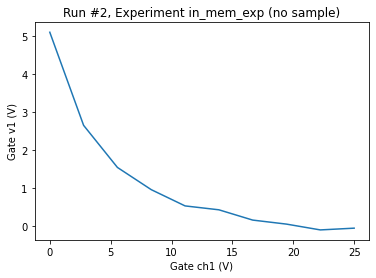

In [14]:
plot_dataset(ds)

When a dataset is loaded using ``load_by_run_spec`` and related functions QCoDeS will first check if the data is available in the database. If not if will check if the data has been exported to ``netcdf`` and then try to load the data from the last known export location. If this fails a warning will be raised and the dataset will be loaded without any raw data.

A dataset can also be loaded directly from the netcdf file. See [Exporting QCoDes Datasets](./Exporting-data-to-other-file-formats.ipynb) for more information on how this is done. Including information about how you can change the ``netcdf`` location.